# Benchmark Analysis - H4

In [266]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [267]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple

%matplotlib inline

In [268]:
matplotlib.style.use('seaborn-v0_8')  

In [269]:
device_name = 'nebulac'
core_list = [1,2,4,8,16,32,64]

In [270]:
#root_dir = '/Users/diego/Desktop/BENCHMARK_NEBULAC_ALL_67M_WITH_BYTES'
root_dir = '/Users/diego/Desktop/BENCHMARK_OLD_DATA/BENCHMARK_NEBULAC_ALL_67M_WITH_BYTES 2'

In [271]:
GCC_TBB_COLOR = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'

NVC_OMP_COLOR = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'

NVC_GPU_COLOR = 'beige'


In [272]:
plot_save_dir = './plots/h4'

## Utils 

In [273]:
def get_path(*entries):
    return os.path.join(*entries)

In [274]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [275]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"),bbox_inches='tight')
    plt.show()

In [276]:
def extraction_pandas_frame_algo(path, COMP="TODO",include_bytes_per_second=False):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                    axis=1)

    if not include_bytes_per_second:
        df = df.drop(columns=['bytes_per_second'])

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev','max','min'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 5 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 5 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    # set max bytes per second
    results_gcc['max_id'] = results_gcc['C'] * 5 + 3
    
    # max bytes per seconds as bytes per second
    if include_bytes_per_second:
        results_gcc['bytes_per_second'] = results_gcc['max_id'].apply(lambda x: df.iloc[x]['bytes_per_second'])

    # min time as real_time
    results_gcc['min_id'] = results_gcc['C'] * 5 + 4
    results_gcc['real_time'] = results_gcc['min_id'].apply(lambda x: df.iloc[x]['real_time'])


    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id','min_id','max_id'], axis=1)
    results_gcc['Compiler'] = 'COMP'
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [277]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO",include_bytes_per_second=False) -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP,include_bytes_per_second=include_bytes_per_second)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [278]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [279]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [280]:
def bytes_per_second_data_algo(compiler_location:str,compiler_name:str,benchmark_name:str) -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_decrement_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{benchmark_name}__Default.csv',COMP=compiler_name,include_bytes_per_second=True)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','real_time'])

    # calc  Mbytes/s
    df[f'{compiler_name}'] = df['bytes_per_second'] * pow(10,-6) # 
    df = df.drop(columns=['bytes_per_second'])
    
    return df

In [281]:

def get_seq_base(benchmark_name:str) -> pd.DataFrame:

    time_filed_name = 'real_time'

    compiler_instances = [
        ('GCC_TBB','GCC(TBB)'),
        ('NVHPC_Multicore','NVC(OMP)')
    ]

    start_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[0][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
    min_val = start_df[time_filed_name].min()
    min_df = start_df


    for i in range(1,len(compiler_instances)):
        current_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[i][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
        current_min = current_df[time_filed_name].min()

        if current_min < min_val:
            min_val = current_min
            min_df = current_df

    return min_df

# H4
> Different compilers/backends may fallback to sequential algorithms, leading to better performance.

## `b4_1_merge_cutoff_wrapper_par`

### Time Comparison - `b4_1_merge_cutoff_wrapper_par`


Check how the runtime without constraining the threads develops with increasing input size

In [282]:
def get_b4_1_merge_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_1_merge_cutoff_wrapper_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_1_merge_cutoff_wrapper_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_1_merge_data_algo(*x) for x in instances]


# merge for plotting 
b4_1_merge_time_merged = pd.merge(*data, on='n')

b4_1_merge_time_merged

,GCC(TBB),n,NVC(OMP)
0,5.272830e+01,4,11793.6
1,5.711070e+01,8,11903.3
2,7.270070e+01,16,11890.0
3,1.099690e+02,32,12065.1
4,1.618770e+02,64,12613.2
5,2.704500e+02,128,12657.6
6,4.863790e+02,256,12385.7
7,9.171700e+02,512,12882.9
8,7.634170e+03,1024,13651.8
9,1.335500e+04,2048,17458.6


### Strong Scaling - `b4_1_merge_cutoff_wrapper_par`
 
1 Million fixed input size with threads 1-64

In [283]:
def get_b4_1_merge_cutoff_wrapper_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = get_seq_base('b4_1_merge_cutoff_wrapper')
    
    ## b4_1_merge_cutoff_wrapper_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_1_merge_cutoff_wrapper_par',
                                               core_list,
                                               COMP=compiler_name
                                            )
    
    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_1_merge_cutoff_wrapper_scaling_algo(*x) for x in instances]

b4_1_merge_cutoff_wrapper_strong_scaling_merged = pd.merge(*data, on='threads')


b4_1_merge_cutoff_wrapper_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.765413,0.480040
1,2,1.328136,0.706517
2,4,2.314363,0.922684
3,8,2.657631,1.078162
4,16,3.274464,1.171035
5,32,4.622114,1.230007
6,64,7.234873,1.194422


In [284]:
# efficiency b4_4_set_difference_cutoff_intersected_par
b4_1_merge_cutoff_wrapper_efficiency = b4_1_merge_cutoff_wrapper_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_1_merge_cutoff_wrapper_efficiency[f'{compiler_name}'] = b4_1_merge_cutoff_wrapper_efficiency[f'{compiler_name}'] / b4_1_merge_cutoff_wrapper_efficiency['threads']
    

b4_1_merge_cutoff_wrapper_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.765413,0.480040
1,2,0.664068,0.353259
2,4,0.578591,0.230671
3,8,0.332204,0.134770
4,16,0.204654,0.073190
5,32,0.144441,0.038438
6,64,0.113045,0.018663


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_18813/1918764186.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


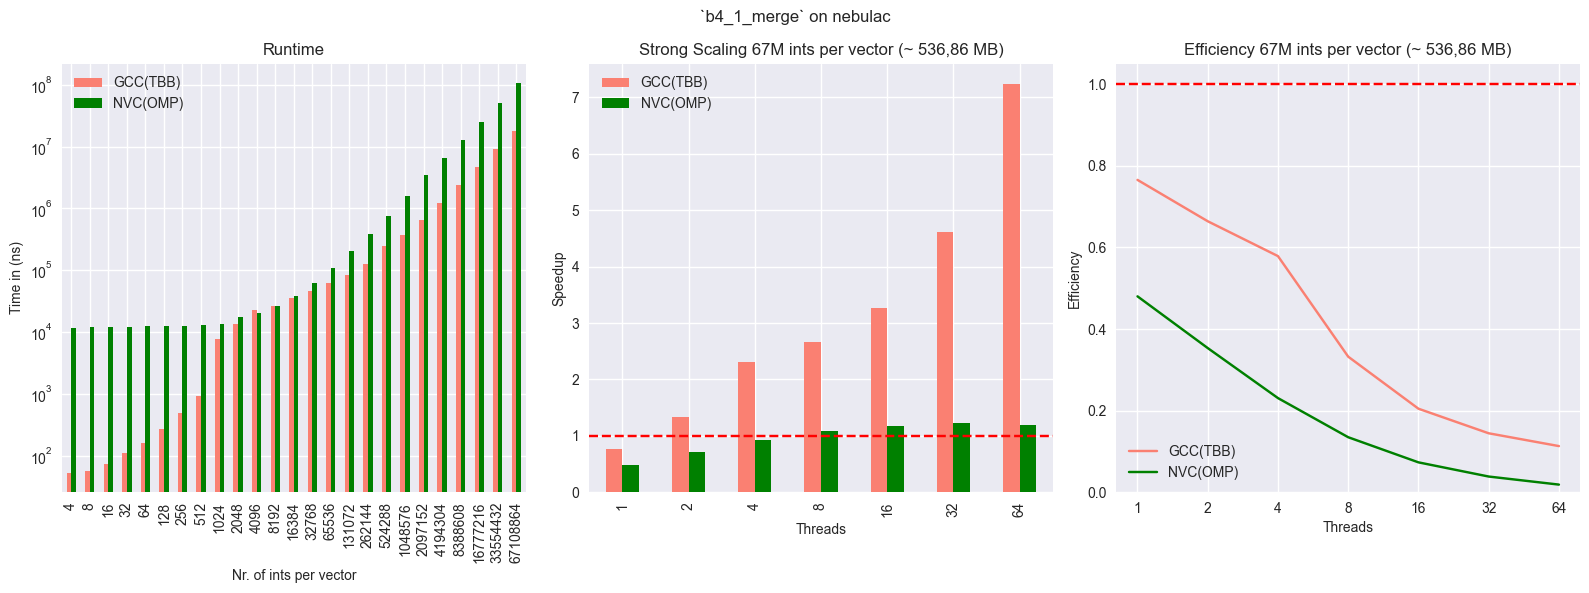

In [285]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b4_1_merge_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_yscale('log', base=10)
ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints per vector')
ax_1.set_title('Runtime')



# plot strong scaling
ax_2 = b4_1_merge_cutoff_wrapper_strong_scaling_merged.plot(kind='bar',
                                                        x='threads',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1]
                                                    )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 67M ints per vector (~ 536,86 MB)')






# plot efficiency
ax_3 = b4_1_merge_cutoff_wrapper_efficiency.plot(x='threads',
                                             color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                             ax=axes[2]
                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 67M ints per vector (~ 536,86 MB)')



fig.suptitle(f"`b4_1_merge` on {device_name}")

fig.tight_layout()

plot(f"`b4_1_merge` {device_name}")

### Mbytes/Seconds

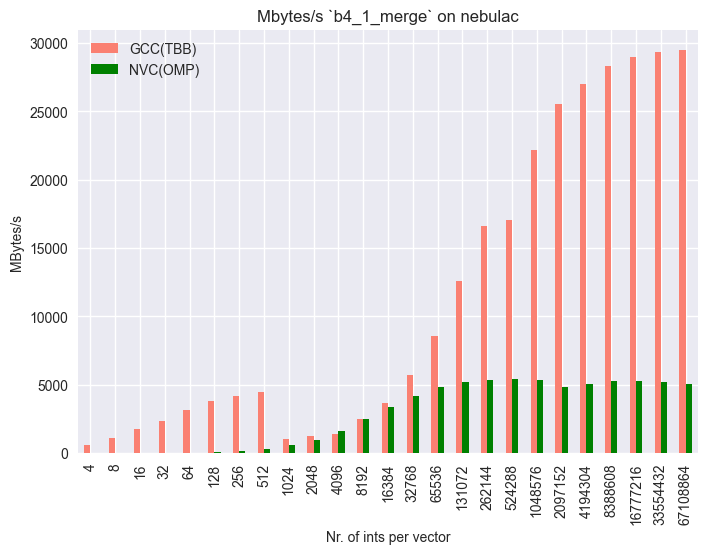

In [286]:
benchmark_name= 'b4_1_merge_cutoff_wrapper_par'
instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [bytes_per_second_data_algo(comp_location,comp_name,benchmark_name) for comp_location,comp_name in instances]

b4_1_mbytes_sec_data = pd.merge(*data, on='n')

# plot mbytes
b4_1_mbytes_sec_data.plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR]
                                                    )


plt.ylabel('MBytes/s')
plt.xlabel('Nr. of ints per vector')
plt.title(f'Mbytes/s `b4_1_merge` on {device_name}')


plot(f'`b4_1_merge` Mbytes_s on {device_name}')

## `b4_2_stable_sort`


### Time Comparison - `b4_2_stable_sort_cutoff_already_sorted_par`

Check how the runtime without constraining the threads develops with increasing input size

In [287]:
def get_b4_2_stable_sort_cutoff_already_sorted_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_already_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_2_stable_sort_cutoff_already_sorted_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_2_stable_sort_cutoff_already_sorted_data_algo(*x) for x in instances]


# merge for plotting
b4_2_stable_sort_cutoff_already_sorted_time_merged = pd.merge(*data, on='n')

b4_2_stable_sort_cutoff_already_sorted_time_merged

,GCC(TBB),n,NVC(OMP)
0,1.257490e+02,4,30129.7
1,1.348430e+02,8,39170.6
2,2.264310e+02,16,49249.9
3,3.426900e+02,32,61714.8
4,6.920350e+02,64,75059.1
5,1.175170e+03,128,76303.5
6,2.363270e+03,256,76549.9
7,1.255700e+04,512,78113.6
8,1.851740e+04,1024,79117.9
9,2.438660e+04,2048,83153.8


### Time Comparison - `b4_2_stable_sort_cutoff_decrement_sorted_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [288]:
def b4_2_stable_sort_cutoff_decrement_sorted_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_decrement_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_2_stable_sort_cutoff_decrement_sorted_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_2_stable_sort_cutoff_decrement_sorted_data_algo(*x) for x in instances]


# merge for plotting
b4_2_stable_sort_cutoff_decrement_sorted_time_merged = pd.merge(*data, on='n')

b4_2_stable_sort_cutoff_decrement_sorted_time_merged

,GCC(TBB),n,NVC(OMP)
0,1.258150e+02,4,27949.8
1,1.353430e+02,8,36580.5
2,2.414550e+02,16,48169.9
3,3.409150e+02,32,58613.6
4,6.904950e+02,64,70614.4
5,1.169580e+03,128,71192.2
6,2.517340e+03,256,80347.2
7,1.240320e+04,512,72229.5
8,1.862310e+04,1024,70908.4
9,2.462890e+04,2048,77749.5


### Time Comparison - `b4_2_stable_sort_cutoff_not_sorted_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [289]:
def b4_2_stable_sort_cutoff_not_sorted_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_not_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_2_stable_sort_cutoff_not_sorted_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_2_stable_sort_cutoff_not_sorted_data_algo(*x) for x in instances]


# merge for plotting
b4_2_stable_sort_cutoff_not_sorted_time_merged = pd.merge(*data, on='n')

b4_2_stable_sort_cutoff_not_sorted_time_merged

,GCC(TBB),n,NVC(OMP)
0,1.258090e+02,4,28435.9
1,1.358310e+02,8,36118.7
2,2.295490e+02,16,42979.8
3,3.380210e+02,32,53766.1
4,6.979100e+02,64,63272.8
5,1.214130e+03,128,72007.4
6,2.374850e+03,256,71403.4
7,1.190600e+04,512,75328.5
8,1.840810e+04,1024,77003.0
9,2.588210e+04,2048,84892.5


### Strong Scaling - `b4_2_stable_sort_cutoff_already_sorted_par`

In [290]:
def get_b4_2_stable_sort_cutoff_already_sorted_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = get_seq_base('b4_2_stable_sort_cutoff_already_sorted')
    
    
    ## b4_2_stable_sort_cutoff_already_sorted_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_2_stable_sort_cutoff_already_sorted_par',
                                               core_list,
                                               COMP=compiler_name
                                            )
    
    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_2_stable_sort_cutoff_already_sorted_scaling_algo(*x) for x in instances]

b4_2_stable_sort_cutoff_already_sorted_strong_scaling_merged = pd.merge(*data, on='threads')

b4_2_stable_sort_cutoff_already_sorted_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,2.160698,0.056297
1,2,4.273013,0.109852
2,4,8.368797,0.212321
3,8,16.609846,0.431488
4,16,31.680811,0.763281
5,32,58.026048,1.372683
6,64,93.495078,1.987961


In [291]:
# efficiency b4_2_stable_sort_cutoff_already_sorted_par
b4_2_stable_sort_cutoff_already_sorted_efficiency = b4_2_stable_sort_cutoff_already_sorted_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_2_stable_sort_cutoff_already_sorted_efficiency[f'{compiler_name}'] = b4_2_stable_sort_cutoff_already_sorted_efficiency[f'{compiler_name}'] / b4_2_stable_sort_cutoff_already_sorted_efficiency['threads']



b4_2_stable_sort_cutoff_already_sorted_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,2.160698,0.056297
1,2,2.136507,0.054926
2,4,2.092199,0.053080
3,8,2.076231,0.053936
4,16,1.980051,0.047705
5,32,1.813314,0.042896
6,64,1.460861,0.031062


### Strong Scaling - `b4_2_stable_sort_cutoff_decrement_sorted_par`

1 Million fixed input size with threads 1-64

In [292]:
def get_b4_2_stable_sort_cutoff_decrement_sorted_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = get_seq_base('b4_2_stable_sort_cutoff_decrement_sorted')
    
    
    ## b4_2_stable_sort_cutoff_decrement_sorted_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_2_stable_sort_cutoff_decrement_sorted_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_2_stable_sort_cutoff_decrement_sorted_scaling_algo(*x) for x in instances]

b4_2_stable_sort_cutoff_decrement_sorted_strong_scaling_merged = pd.merge(*data, on='threads')

b4_2_stable_sort_cutoff_decrement_sorted_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.021442,0.073741
1,2,1.947531,0.143253
2,4,3.706793,0.269704
3,8,11.845393,0.548329
4,16,27.833151,0.969327
5,32,61.387782,1.806399
6,64,99.181977,2.489581


In [293]:
# efficiency b4_2_stable_sort_cutoff_decrement_sorted_par
b4_2_stable_sort_cutoff_decrement_sorted_efficiency = b4_2_stable_sort_cutoff_decrement_sorted_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_2_stable_sort_cutoff_decrement_sorted_efficiency[f'{compiler_name}'] = b4_2_stable_sort_cutoff_decrement_sorted_efficiency[f'{compiler_name}'] / b4_2_stable_sort_cutoff_decrement_sorted_efficiency['threads']



b4_2_stable_sort_cutoff_decrement_sorted_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.021442,0.073741
1,2,0.973765,0.071627
2,4,0.926698,0.067426
3,8,1.480674,0.068541
4,16,1.739572,0.060583
5,32,1.918368,0.056450
6,64,1.549718,0.038900


### Strong Scaling - `b4_2_stable_sort_cutoff_not_sorted_par`

1 Million fixed input size with threads 1-64

In [294]:
def get_b4_2_stable_sort_cutoff_not_sorted_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = get_seq_base('b4_2_stable_sort_cutoff_not_sorted')
    
    
    ## b4_2_stable_sort_cutoff_not_sorted_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_2_stable_sort_cutoff_not_sorted_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_2_stable_sort_cutoff_not_sorted_scaling_algo(*x) for x in instances]

b4_2_stable_sort_cutoff_not_sorted_strong_scaling_merged = pd.merge(*data, on='threads')

b4_2_stable_sort_cutoff_not_sorted_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.970841,3.222459
1,2,1.906840,4.345508
2,4,3.768643,5.286612
3,8,7.150625,5.879000
4,16,31.059612,6.249363
5,32,124.124635,6.604563
6,64,247.292308,6.551636


In [295]:
# efficiency b4_2_stable_sort_cutoff_not_sorted_par
b4_2_stable_sort_cutoff_not_sorted_efficiency = b4_2_stable_sort_cutoff_not_sorted_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_2_stable_sort_cutoff_not_sorted_efficiency[f'{compiler_name}'] = b4_2_stable_sort_cutoff_not_sorted_efficiency[f'{compiler_name}'] / b4_2_stable_sort_cutoff_not_sorted_efficiency['threads']



b4_2_stable_sort_cutoff_not_sorted_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.970841,3.222459
1,2,0.953420,2.172754
2,4,0.942161,1.321653
3,8,0.893828,0.734875
4,16,1.941226,0.390585
5,32,3.878895,0.206393
6,64,3.863942,0.102369


### Plotting

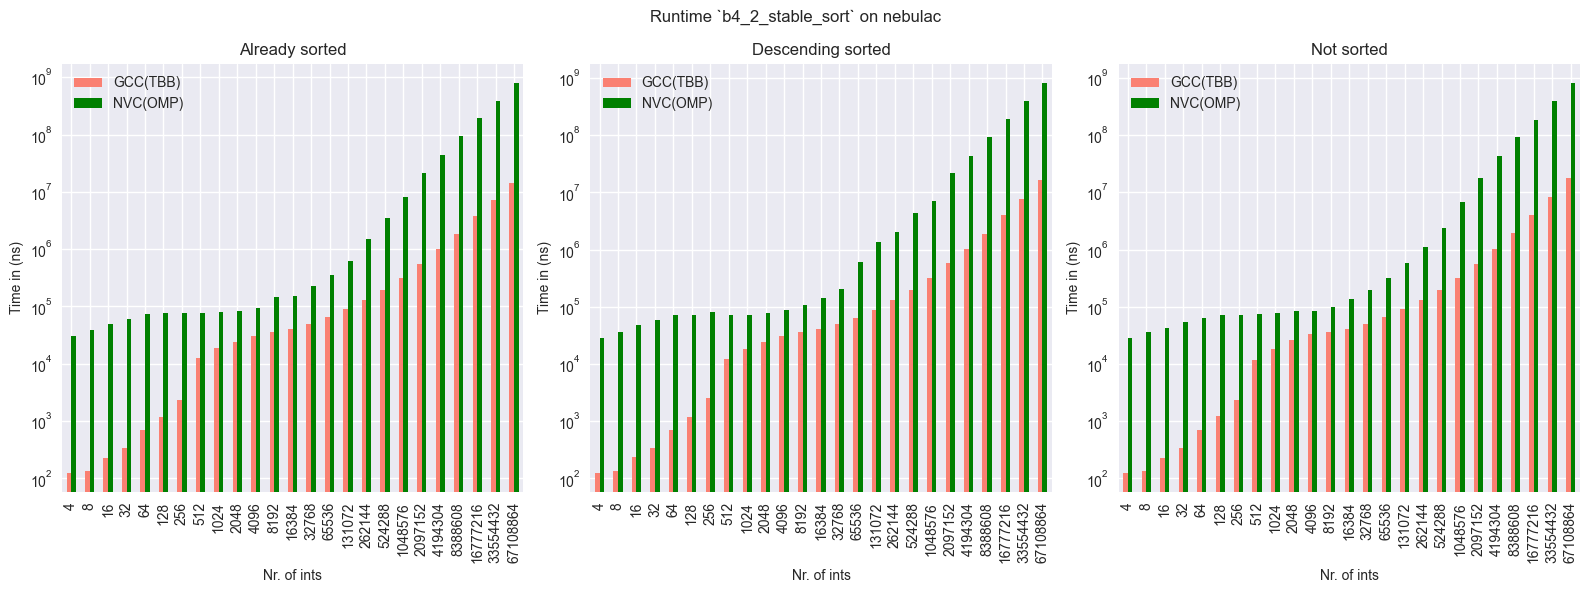

In [296]:
### Runtime

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_2_stable_sort_cutoff_already_sorted_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_yscale('log', base=10)
ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Already sorted')


# decrement sorted
ax_2 = b4_2_stable_sort_cutoff_decrement_sorted_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_yscale('log', base=10)
ax_2.set_ylabel('Time in (ns)')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Descending sorted')


# not sorted
ax_3 = b4_2_stable_sort_cutoff_not_sorted_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_yscale('log', base=10)
ax_3.set_ylabel('Time in (ns)')
ax_3.set_xlabel('Nr. of ints')
ax_3.set_title('Not sorted')

fig.suptitle(f"Runtime `b4_2_stable_sort` on {device_name}")

fig.tight_layout()

plot(f"`b4_2_stable_sort` Runtime on {device_name}")


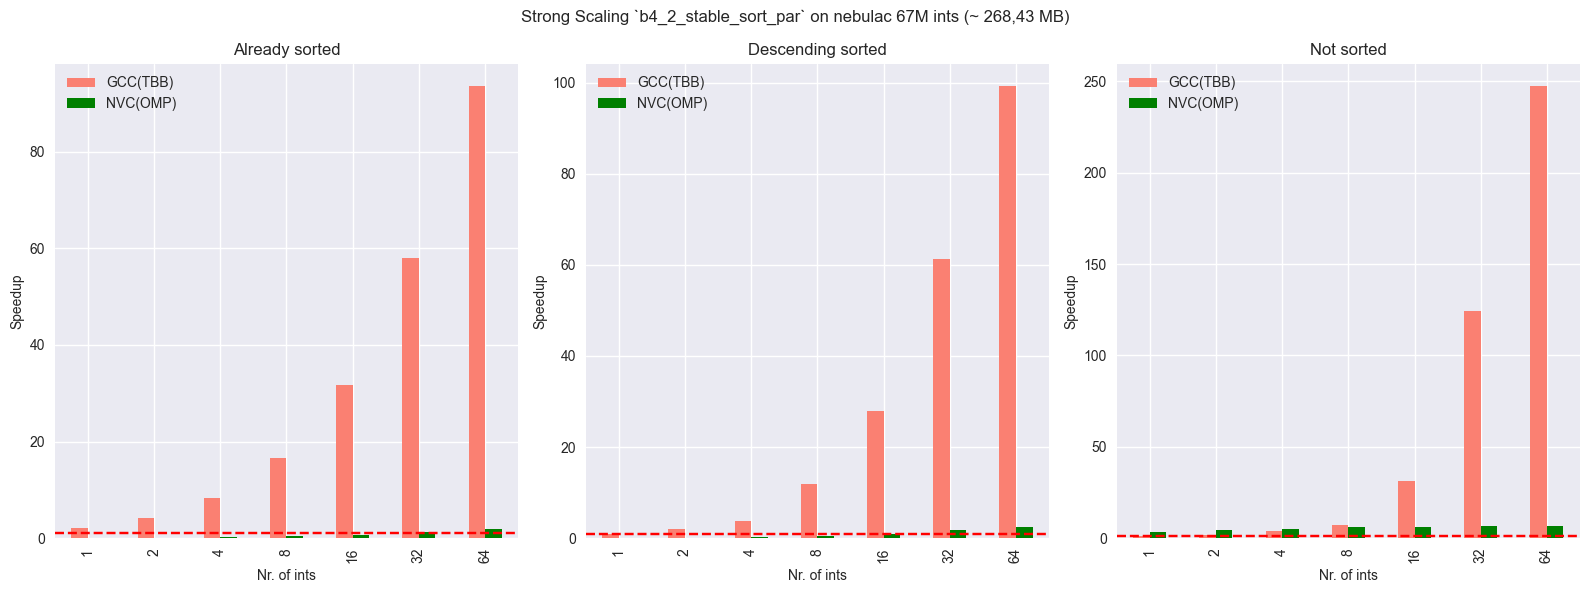

In [297]:
## stable sort strong scaling graphs


fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_2_stable_sort_cutoff_already_sorted_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_ylabel('Speedup')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Already sorted')
ax_1.axhline(y=1,color='r', linestyle='--')


# decrement sorted
ax_2 = b4_2_stable_sort_cutoff_decrement_sorted_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Descending sorted')
ax_2.axhline(y=1,color='r', linestyle='--')


# not sorted
ax_3 = b4_2_stable_sort_cutoff_not_sorted_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_ylabel('Speedup')
ax_3.set_xlabel('Nr. of ints')
ax_3.set_title('Not sorted')
ax_3.axhline(y=1,color='r', linestyle='--')

fig.suptitle(f"Strong Scaling `b4_2_stable_sort_par` on {device_name} 67M ints (~ 268,43 MB)")

fig.tight_layout()

plot(f"`b4_2_stable_sort` Strong Scaling on {device_name} 2^26 ints (~ 268,43 MB)")


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_18813/2749386026.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_18813/2749386026.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_18813/2749386026.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


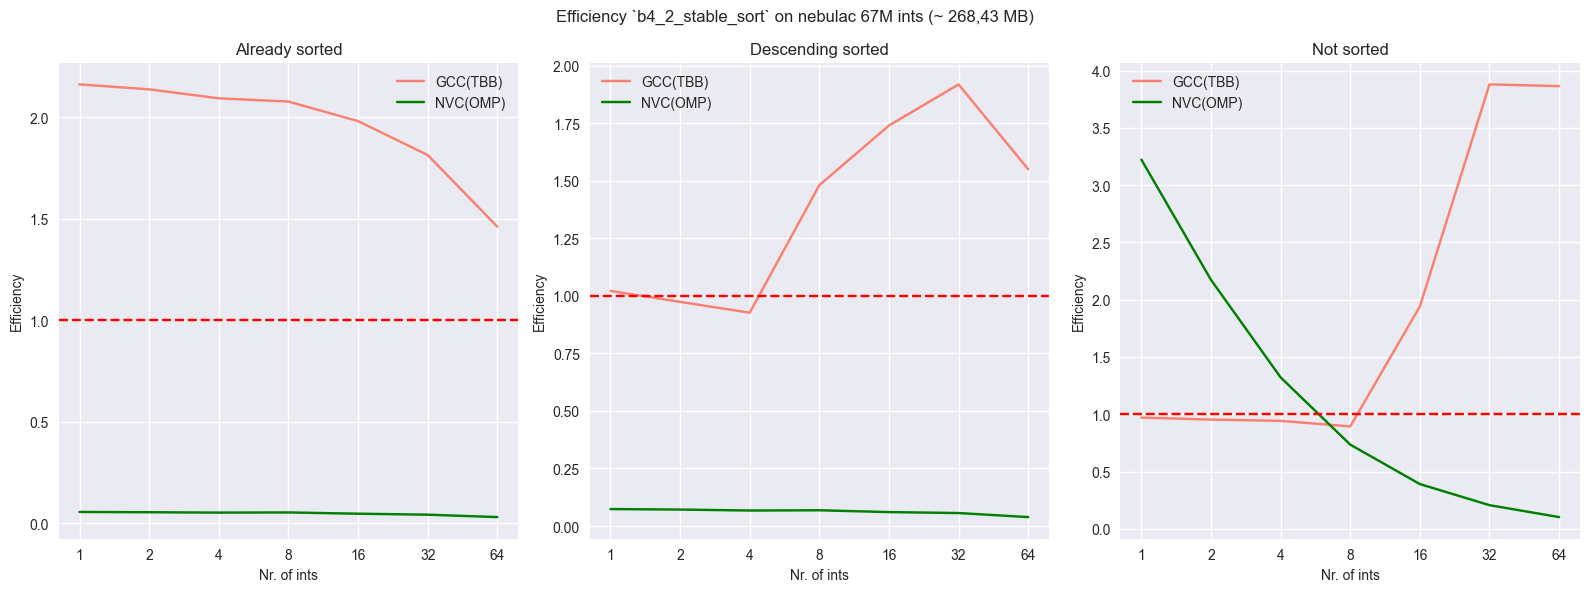

In [298]:
### efficiency stable sort

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_2_stable_sort_cutoff_already_sorted_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_ylabel('Efficiency')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Already sorted')
ax_1.axhline(y=1,color='r', linestyle='--')

#ax_1.set_ylim(0,1.05)

ax_1.set_xscale('log', base=2)
current_values = ax_1.get_xticks()
ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# decrement sorted
ax_2 = b4_2_stable_sort_cutoff_decrement_sorted_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_ylabel('Efficiency')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Descending sorted')
ax_2.axhline(y=1,color='r', linestyle='--')

#ax_2.set_ylim(0,1.05)

ax_2.set_xscale('log', base=2)
current_values = ax_2.get_xticks()
ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# not sorted
ax_3 = b4_2_stable_sort_cutoff_not_sorted_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Nr. of ints')
ax_3.set_title('Not sorted')
ax_3.axhline(y=1,color='r', linestyle='--')



ax_3.set_xscale('log', base=2)
current_values = ax_3.get_xticks()
ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


fig.suptitle(f"Efficiency `b4_2_stable_sort` on {device_name} 67M ints (~ 268,43 MB)")

fig.tight_layout()

plot(f"`b4_2_stable_sort` Efficiency on {device_name} 2^26 ints (~ 268,43 MB)")

### Mbytes/s

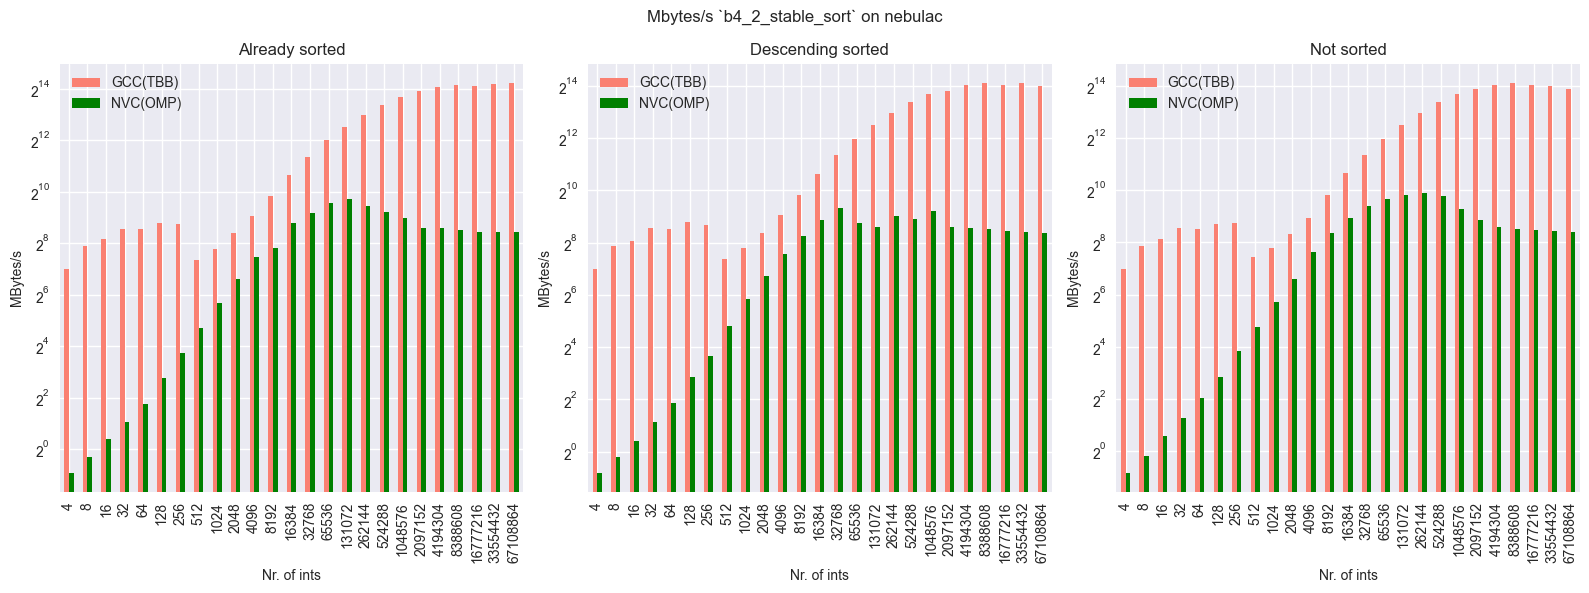

In [299]:
benchmark_names = [
    'b4_2_stable_sort_cutoff_already_sorted_par',
    'b4_2_stable_sort_cutoff_decrement_sorted_par',
    'b4_2_stable_sort_cutoff_not_sorted_par'
]


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

b4_2_mbytes_sec_data = {}

for benchmark_name in benchmark_names:
    # collect data for instances
    data = [bytes_per_second_data_algo(comp_location,comp_name,benchmark_name) for comp_location,comp_name in instances]

    b4_2_mbytes_sec_data[benchmark_name] = pd.merge(*data, on='n')


fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))



# plot already sorted
ax_1 = b4_2_mbytes_sec_data['b4_2_stable_sort_cutoff_already_sorted_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[0]
                                                    )


ax_1.set_yscale('log',base=2)
ax_1.set_ylabel('MBytes/s')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Already sorted')




# plot decrement_sorted
ax_2 = b4_2_mbytes_sec_data['b4_2_stable_sort_cutoff_decrement_sorted_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1]
                                                    )


ax_2.set_yscale('log',base=2)
ax_2.set_ylabel('MBytes/s')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Descending sorted')


# plot not_sorted
ax_3 = b4_2_mbytes_sec_data['b4_2_stable_sort_cutoff_not_sorted_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[2]
                                                    )

ax_3.set_yscale('log',base=2)
ax_3.set_ylabel('MBytes/s')
ax_3.set_xlabel('Nr. of ints')
ax_3.set_title('Not sorted')


fig.suptitle(f"Mbytes/s `b4_2_stable_sort` on {device_name}")

fig.tight_layout()

plot(f"`b4_2_stable_sort` Mbytes_s on {device_name}")

## `b4_3_set_union`

### Time Comparison - `b4_3_set_union_cutoff_one_empty_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [300]:
def b4_3_set_union_cutoff_one_empty_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_3_set_union_cutoff_one_empty_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_3_set_union_cutoff_one_empty_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_3_set_union_cutoff_one_empty_data_algo(*x) for x in instances]


# merge for plotting
b4_3_set_union_cutoff_one_empty_time_merged = pd.merge(*data, on='n')

b4_3_set_union_cutoff_one_empty_time_merged

,GCC(TBB),n,NVC(OMP)
0,4.814900e+01,4,10531.0
1,4.962830e+01,8,10609.5
2,5.036570e+01,16,11148.7
3,5.063790e+01,32,12018.0
4,5.067230e+01,64,13586.7
5,6.115110e+01,128,12537.0
6,8.019310e+01,256,11708.6
7,1.122750e+02,512,11787.8
8,3.968530e+04,1024,11251.1
9,4.530370e+04,2048,11433.5


### Time Comparison - `b4_3_set_union_cutoff_one_wholly_greater_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [301]:
def b4_3_set_union_cutoff_one_wholly_greater_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_3_set_union_cutoff_one_wholly_greater_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_3_set_union_cutoff_one_wholly_greater_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_3_set_union_cutoff_one_wholly_greater_data_algo(*x) for x in instances]


# merge for plotting
b4_3_set_union_cutoff_one_wholly_greater_time_merged = pd.merge(*data, on='n')

b4_3_set_union_cutoff_one_wholly_greater_time_merged

,GCC(TBB),n,NVC(OMP)
0,5.085900e+01,4,10569.4
1,5.364540e+01,8,10709.3
2,5.988900e+01,16,11580.5
3,8.167560e+01,32,12760.0
4,1.393170e+02,64,14205.5
5,2.155550e+02,128,12780.4
6,3.624590e+02,256,12280.8
7,4.419020e+04,512,12203.3
8,4.829400e+04,1024,12565.3
9,5.588380e+04,2048,13161.1


### Time Comparison - `b4_3_set_union_cutoff_front_overhang_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [302]:
def b4_3_set_union_cutoff_front_overhang_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_3_set_union_cutoff_front_overhang_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_3_set_union_cutoff_front_overhang_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_3_set_union_cutoff_front_overhang_data_algo(*x) for x in instances]


# merge for plotting
b4_3_set_union_cutoff_front_overhang_time_merged = pd.merge(*data, on='n')

b4_3_set_union_cutoff_front_overhang_time_merged

,GCC(TBB),n,NVC(OMP)
0,5.060780e+01,4,13124.2
1,5.514510e+01,8,12887.4
2,6.718480e+01,16,11876.4
3,9.952600e+01,32,11961.0
4,1.576580e+02,64,12326.5
5,2.647530e+02,128,13566.9
6,4.703790e+02,256,13333.5
7,1.119860e+05,512,13391.2
8,1.136060e+05,1024,13745.2
9,1.267060e+05,2048,14662.8


### Strong Scaling - `b4_3_set_union_cutoff_one_empty_par`

1 Million fixed input size with threads 1-64

In [303]:
def get_b4_3_set_union_cutoff_one_empty_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = get_seq_base('b4_3_set_union_cutoff_one_empty')
    
    ## b4_3_set_union_cutoff_one_empty_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_3_set_union_cutoff_one_empty_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_3_set_union_cutoff_one_empty_scaling_algo(*x) for x in instances]

b4_3_set_union_cutoff_one_empty_strong_scaling_merged = pd.merge(*data, on='threads')

b4_3_set_union_cutoff_one_empty_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.693177,0.076827
1,2,0.904074,0.153673
2,4,1.692445,0.306946
3,8,2.414483,0.612966
4,16,2.797586,1.225016
5,32,2.957027,2.439201
6,64,3.046965,4.551742


In [304]:
# efficiency b4_3_set_union_cutoff_one_empty_par
b4_3_set_union_cutoff_one_empty_efficiency = b4_3_set_union_cutoff_one_empty_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_3_set_union_cutoff_one_empty_efficiency[f'{compiler_name}'] = b4_3_set_union_cutoff_one_empty_efficiency[f'{compiler_name}'] / b4_3_set_union_cutoff_one_empty_efficiency['threads']



b4_3_set_union_cutoff_one_empty_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.693177,0.076827
1,2,0.452037,0.076836
2,4,0.423111,0.076736
3,8,0.301810,0.076621
4,16,0.174849,0.076563
5,32,0.092407,0.076225
6,64,0.047609,0.071121


### Strong Scaling - `b4_3_set_union_cutoff_one_wholly_greater_par`

1 Million fixed input size with threads 1-64

In [305]:
def get_b4_3_set_union_cutoff_one_wholly_greater_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    sq_base = get_seq_base('b4_3_set_union_cutoff_one_wholly_greater')
    
    ## b4_3_set_union_cutoff_one_wholly_greater_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_3_set_union_cutoff_one_wholly_greater_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_3_set_union_cutoff_one_wholly_greater_scaling_algo(*x) for x in instances]

b4_3_set_union_cutoff_one_wholly_greater_strong_scaling_merged = pd.merge(*data, on='threads')

b4_3_set_union_cutoff_one_wholly_greater_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.422324,0.257350
1,2,1.868081,0.432905
2,4,3.726918,0.651498
3,8,4.763575,0.856883
4,16,5.608623,1.001040
5,32,6.080598,1.123453
6,64,6.420918,1.111438


In [306]:

# efficiency b4_3_set_union_cutoff_one_wholly_greater_par
b4_3_set_union_cutoff_one_wholly_greater_efficiency = b4_3_set_union_cutoff_one_wholly_greater_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_3_set_union_cutoff_one_wholly_greater_efficiency[f'{compiler_name}'] = b4_3_set_union_cutoff_one_wholly_greater_efficiency[f'{compiler_name}'] / b4_3_set_union_cutoff_one_wholly_greater_efficiency['threads']



b4_3_set_union_cutoff_one_wholly_greater_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.422324,0.257350
1,2,0.934041,0.216452
2,4,0.931730,0.162874
3,8,0.595447,0.107110
4,16,0.350539,0.062565
5,32,0.190019,0.035108
6,64,0.100327,0.017366


### Strong Scaling - `b4_3_set_union_cutoff_front_overhang_par`

1 Million fixed input size with threads 1-64

In [307]:
def get_b4_3_set_union_cutoff_front_overhang_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    sq_base = get_seq_base('b4_3_set_union_cutoff_front_overhang')
    
    ## b4_3_set_union_cutoff_front_overhang_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_3_set_union_cutoff_front_overhang_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_3_set_union_cutoff_front_overhang_scaling_algo(*x) for x in instances]

b4_3_set_union_cutoff_front_overhang_strong_scaling_merged = pd.merge(*data, on='threads')

b4_3_set_union_cutoff_front_overhang_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.783217,0.451604
1,2,1.168594,0.686503
2,4,1.837578,0.831103
3,8,1.692483,1.006230
4,16,1.837483,1.068615
5,32,1.798147,1.087164
6,64,1.796235,1.050669


In [308]:
# efficiency b4_3_set_union_cutoff_front_overhang_par
b4_3_set_union_cutoff_front_overhang_efficiency = b4_3_set_union_cutoff_front_overhang_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_3_set_union_cutoff_front_overhang_efficiency[f'{compiler_name}'] = b4_3_set_union_cutoff_front_overhang_efficiency[f'{compiler_name}'] / b4_3_set_union_cutoff_front_overhang_efficiency['threads']



b4_3_set_union_cutoff_front_overhang_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.783217,0.451604
1,2,0.584297,0.343252
2,4,0.459394,0.207776
3,8,0.211560,0.125779
4,16,0.114843,0.066788
5,32,0.056192,0.033974
6,64,0.028066,0.016417


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_18813/1367863599.py:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_1.set_ylim(0,y_lim)
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_18813/1367863599.py:23: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_2.set_ylim(0,y_lim)
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_18813/1367863599.py:33: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_3.set_ylim(0,y_lim)


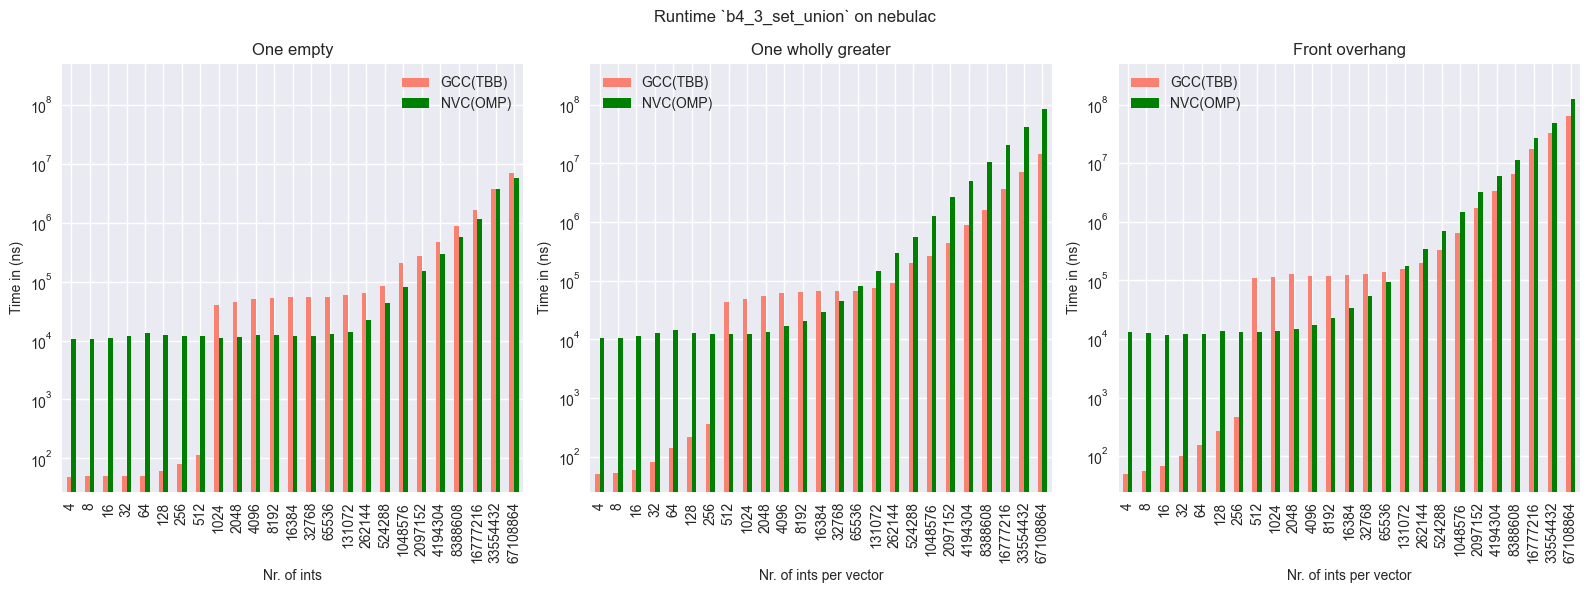

In [309]:
# all set_union graphs

y_lim = 5*pow(10,8)
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_3_set_union_cutoff_one_empty_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_yscale('log', base=10)
ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('One empty')
ax_1.set_ylim(0,y_lim)

# decrement sorted
ax_2 = b4_3_set_union_cutoff_one_wholly_greater_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_yscale('log', base=10)
ax_2.set_ylabel('Time in (ns)')
ax_2.set_xlabel('Nr. of ints per vector')
ax_2.set_title('One wholly greater')
ax_2.set_ylim(0,y_lim)


# not sorted
ax_3 = b4_3_set_union_cutoff_front_overhang_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_yscale('log', base=10)
ax_3.set_ylabel('Time in (ns)')
ax_3.set_xlabel('Nr. of ints per vector')
ax_3.set_title('Front overhang')
ax_3.set_ylim(0,y_lim)

fig.suptitle(f"Runtime `b4_3_set_union` on {device_name}")

fig.tight_layout()

plot(f"`b4_3_set_union` Runtime on {device_name}")

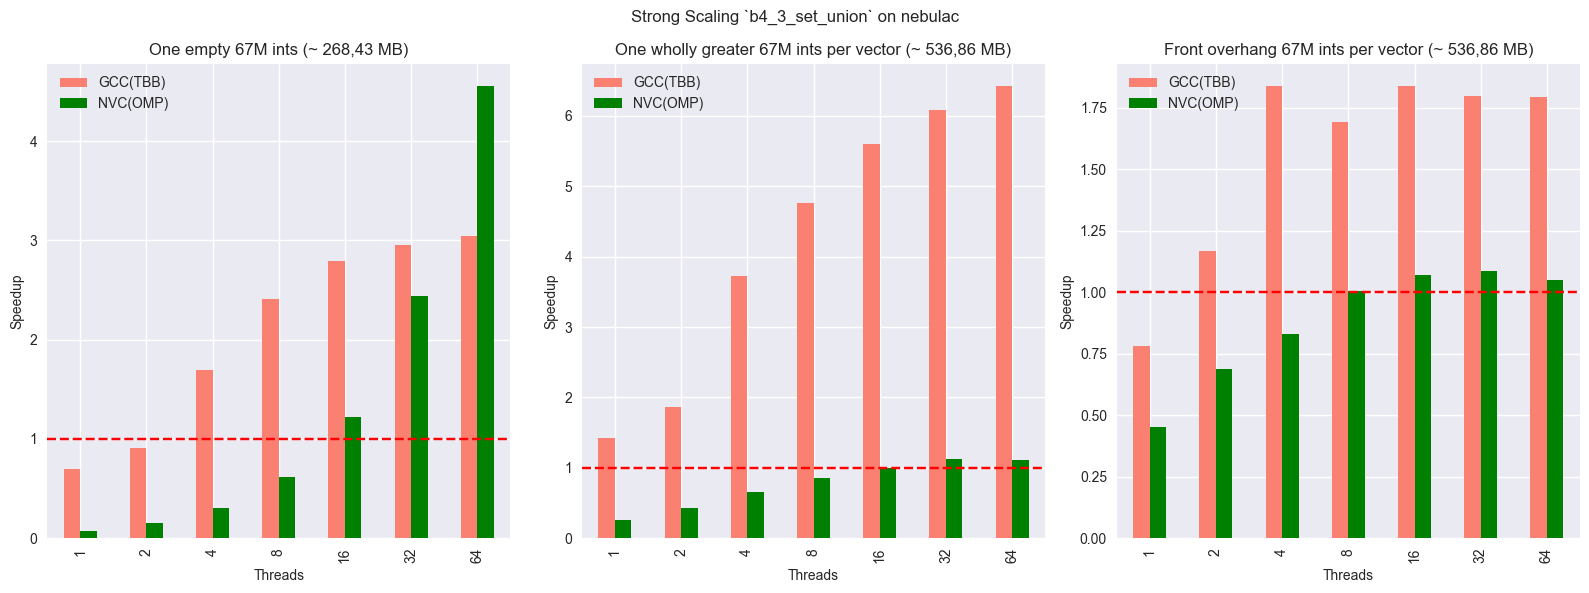

In [310]:
# all set_union graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_3_set_union_cutoff_one_empty_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_ylabel('Speedup')
ax_1.set_xlabel('Threads')
ax_1.set_title('One empty 67M ints (~ 268,43 MB)')
ax_1.axhline(y=1, color='r',linestyle='--')
#ax_1.set_ylim(0,3)

# decrement sorted
ax_2 = b4_3_set_union_cutoff_one_wholly_greater_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('One wholly greater 67M ints per vector (~ 536,86 MB)')
ax_2.axhline(y=1, color='r',linestyle='--')
#ax_2.set_ylim(0,3)


# not sorted
ax_3 = b4_3_set_union_cutoff_front_overhang_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_ylabel('Speedup')
ax_3.set_xlabel('Threads')
ax_3.set_title('Front overhang 67M ints per vector (~ 536,86 MB)')
ax_3.axhline(y=1, color='r',linestyle='--')
#ax_3.set_ylim(0,3)


fig.suptitle(f"Strong Scaling `b4_3_set_union` on {device_name}")

fig.tight_layout()

plot(f"`b4_3_set_union` Strong Scaling on {device_name}")

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_18813/165932189.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_18813/165932189.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_18813/165932189.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


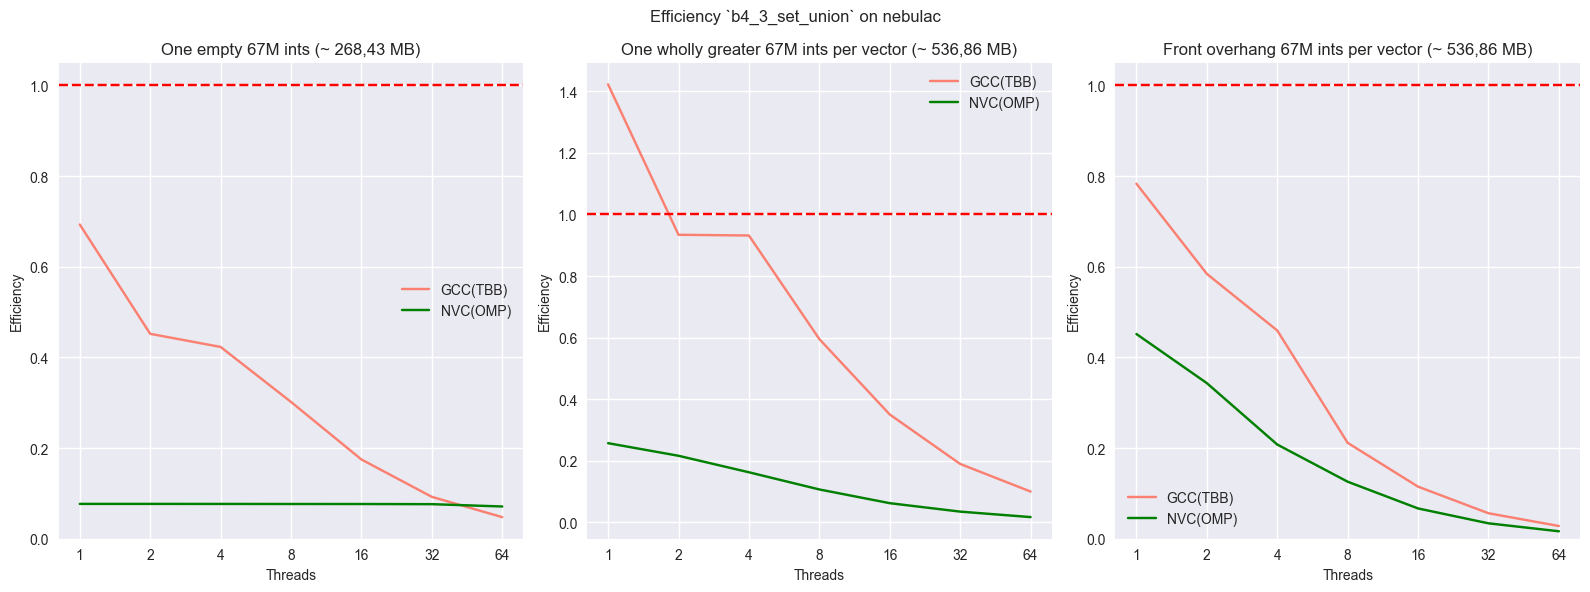

In [311]:
# efficiency  set_union graphs


fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_3_set_union_cutoff_one_empty_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_ylabel('Efficiency')
ax_1.set_xlabel('Threads')
ax_1.set_title('One empty 67M ints (~ 268,43 MB)')
ax_1.axhline(y=1, color='r',linestyle='--')
ax_1.set_ylim(0,1.05)

ax_1.set_xscale('log', base=2)
current_values = ax_1.get_xticks()
ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# decrement sorted
ax_2 = b4_3_set_union_cutoff_one_wholly_greater_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_ylabel('Efficiency')
ax_2.set_xlabel('Threads')
ax_2.set_title('One wholly greater 67M ints per vector (~ 536,86 MB)')
ax_2.axhline(y=1, color='r',linestyle='--')
#ax_2.set_ylim(0,1.05)

ax_2.set_xscale('log', base=2)
current_values = ax_2.get_xticks()
ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# not sorted
ax_3 = b4_3_set_union_cutoff_front_overhang_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Front overhang 67M ints per vector (~ 536,86 MB)')
ax_3.axhline(y=1, color='r',linestyle='--')
ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = ax_3.get_xticks()
ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


fig.suptitle(f"Efficiency `b4_3_set_union` on {device_name}")

fig.tight_layout()

plot(f"`b4_3_set_union` Efficiency on {device_name}")

### Mbytes/s

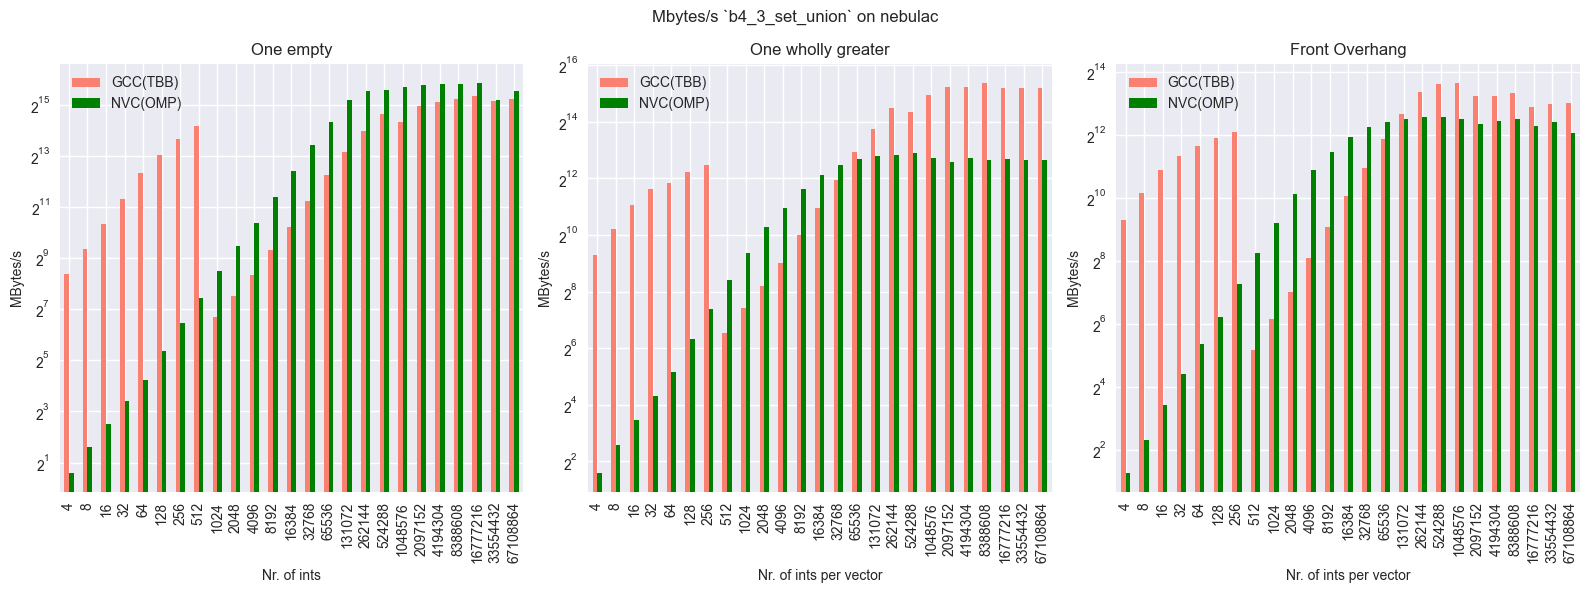

In [312]:
benchmark_names = [
    'b4_3_set_union_cutoff_one_empty_par',
    'b4_3_set_union_cutoff_one_wholly_greater_par',
    'b4_3_set_union_cutoff_front_overhang_par'
]


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

b4_3_mbytes_sec_data = {}

for benchmark_name in benchmark_names:
    # collect data for instances
    data = [bytes_per_second_data_algo(comp_location,comp_name,benchmark_name) for comp_location,comp_name in instances]

    b4_3_mbytes_sec_data[benchmark_name] = pd.merge(*data, on='n')


fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))

#ylim = (0,pow(2,15))


# plot one empty
ax_1 = b4_3_mbytes_sec_data['b4_3_set_union_cutoff_one_empty_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[0]
                                                    )


ax_1.set_yscale('log',base=2)
ax_1.set_ylabel('MBytes/s')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('One empty')
#ax_1.set_ylim(0,2*pow(2,14))



# plot wholey greater
ax_2 = b4_3_mbytes_sec_data['b4_3_set_union_cutoff_one_wholly_greater_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1]
                                                    )


ax_2.set_yscale('log',base=2)
ax_2.set_ylabel('MBytes/s')
ax_2.set_xlabel('Nr. of ints per vector')
ax_2.set_title('One wholly greater')
#ax_2.set_ylim(*ylim)


# plot front_overhang
ax_3 = b4_3_mbytes_sec_data['b4_3_set_union_cutoff_front_overhang_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[2]
                                                    )

ax_3.set_yscale('log',base=2)
ax_3.set_ylabel('MBytes/s')
ax_3.set_xlabel('Nr. of ints per vector')
ax_3.set_title('Front Overhang')
#ax_3.set_ylim(*ylim)


fig.suptitle(f"Mbytes/s `b4_3_set_union` on {device_name}")

fig.tight_layout()

plot(f"`b4_3_set_union` Mbytes_s on {device_name}")

## `b4_4_set_difference`

### Time Comparison - `b4_4_set_difference_cutoff_left_empty_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [313]:
def b4_4_set_difference_cutoff_left_empty_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_4_set_difference_cutoff_left_empty_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_left_empty_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_4_set_difference_cutoff_left_empty_data_algo(*x) for x in instances]


# merge for plotting
b4_4_set_difference_cutoff_left_empty_time_merged = pd.merge(*data, on='n')

b4_4_set_difference_cutoff_left_empty_time_merged

,GCC(TBB),n,NVC(OMP)
0,51.0543,4,50.8084
1,51.0323,8,50.6814
2,51.0450,16,50.4128
3,51.1007,32,50.3684
4,51.0724,64,50.2940
5,51.0774,128,50.2953
6,51.0612,256,50.2651
7,51.0800,512,50.9091
8,51.0787,1024,50.2281
9,51.0589,2048,50.2633


### Time Comparison - `b4_4_set_difference_cutoff_right_empty_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [314]:
def b4_4_set_difference_cutoff_right_empty_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_4_set_difference_cutoff_right_empty_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_right_empty_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_4_set_difference_cutoff_right_empty_data_algo(*x) for x in instances]


# merge for plotting
b4_4_set_difference_cutoff_right_empty_time_merged = pd.merge(*data, on='n')

b4_4_set_difference_cutoff_right_empty_time_merged

,GCC(TBB),n,NVC(OMP)
0,5331.49,4,8526.96
1,15192.60,8,8590.11
2,19425.60,16,9761.23
3,26664.90,32,11005.20
4,30247.90,64,11343.80
5,31618.20,128,10220.90
6,34520.40,256,10050.50
7,36597.40,512,9221.12
8,39116.80,1024,10352.10
9,44804.00,2048,9004.64


### Time Comparison - `b4_4_set_difference_cutoff_wholly_greater_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [315]:
def b4_4_set_difference_cutoff_wholly_greater_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_4_set_difference_cutoff_wholly_greater_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_wholly_greater_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_4_set_difference_cutoff_wholly_greater_data_algo(*x) for x in instances]


# merge for plotting
b4_4_set_difference_cutoff_wholly_greater_time_merged = pd.merge(*data, on='n')

b4_4_set_difference_cutoff_wholly_greater_time_merged

,GCC(TBB),n,NVC(OMP)
0,5621.72,4,5.246650e+01
1,10684.80,8,5.615700e+01
2,16467.50,16,6.356330e+01
3,21799.10,32,8.291870e+01
4,25367.10,64,1.386740e+02
5,27435.80,128,2.027410e+02
6,31221.40,256,3.310800e+02
7,34246.60,512,5.877480e+02
8,38799.30,1024,1.101510e+03
9,43329.10,2048,2.128080e+03


### Time Comparison - `b4_4_set_difference_cutoff_intersected_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [316]:
def b4_4_set_difference_cutoff_intersected_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_4_set_difference_cutoff_intersected_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_intersected_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_4_set_difference_cutoff_intersected_data_algo(*x) for x in instances]


# merge for plotting
b4_4_set_difference_cutoff_intersected_time_merged = pd.merge(*data, on='n')

b4_4_set_difference_cutoff_intersected_time_merged

,GCC(TBB),n,NVC(OMP)
0,5.842700e+01,4,5.379760e+01
1,7.049590e+01,8,5.813730e+01
2,1.070990e+02,16,6.909260e+01
3,1.673590e+02,32,9.273810e+01
4,2.832700e+02,64,1.526270e+02
5,5.090000e+02,128,2.180350e+02
6,9.614710e+02,256,3.493560e+02
7,1.059990e+05,512,6.067130e+02
8,1.056480e+05,1024,1.115920e+03
9,1.053420e+05,2048,2.141510e+03


### Strong Scaling - `b4_4_set_difference_cutoff_left_empty_par`

1 Million fixed input size with threads 1-64

In [317]:
def get_b4_4_set_difference_cutoff_left_empty_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    sq_base = get_seq_base('b4_4_set_difference_cutoff_left_empty')
    
    
    ## b4_4_set_difference_cutoff_left_empty_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_4_set_difference_cutoff_left_empty_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_4_set_difference_cutoff_left_empty_scaling_algo(*x) for x in instances]

b4_4_set_difference_cutoff_left_empty_strong_scaling_merged = pd.merge(*data, on='threads')

b4_4_set_difference_cutoff_left_empty_strong_scaling_merged


,threads,GCC(TBB),NVC(OMP)
0,1,0.906712,0.939368
1,2,0.905811,0.939126
2,4,0.907391,0.936765
3,8,0.903831,0.939596
4,16,0.902839,0.929626
5,32,0.930860,0.937632
6,64,0.921230,0.938253


In [318]:
# efficiency b4_4_set_difference_cutoff_left_empty_par
b4_4_set_difference_cutoff_left_empty_efficiency = b4_4_set_difference_cutoff_left_empty_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_4_set_difference_cutoff_left_empty_efficiency[f'{compiler_name}'] = b4_4_set_difference_cutoff_left_empty_efficiency[f'{compiler_name}'] / b4_4_set_difference_cutoff_left_empty_efficiency['threads']



b4_4_set_difference_cutoff_left_empty_efficiency


,threads,GCC(TBB),NVC(OMP)
0,1,0.906712,0.939368
1,2,0.452906,0.469563
2,4,0.226848,0.234191
3,8,0.112979,0.117450
4,16,0.056427,0.058102
5,32,0.029089,0.029301
6,64,0.014394,0.014660


### Strong Scaling - `b4_4_set_difference_cutoff_right_empty_par`

1 Million fixed input size with threads 1-64

In [319]:
def get_b4_4_set_difference_cutoff_right_empty_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    

    ## seq base
    sq_base = get_seq_base('b4_4_set_difference_cutoff_right_empty')
    
    ## b4_4_set_difference_cutoff_right_empty_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_4_set_difference_cutoff_right_empty_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_4_set_difference_cutoff_right_empty_scaling_algo(*x) for x in instances]

b4_4_set_difference_cutoff_right_empty_strong_scaling_merged = pd.merge(*data, on='threads')

b4_4_set_difference_cutoff_right_empty_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.702950,0.077919
1,2,0.916379,0.155889
2,4,2.034596,0.310894
3,8,2.299564,0.622047
4,16,2.855651,1.240034
5,32,3.021504,2.472597
6,64,3.155280,4.722693


In [320]:
# efficiency b4_4_set_difference_cutoff_right_empty_par
b4_4_set_difference_cutoff_right_empty_efficiency = b4_4_set_difference_cutoff_right_empty_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_4_set_difference_cutoff_right_empty_efficiency[f'{compiler_name}'] = b4_4_set_difference_cutoff_right_empty_efficiency[f'{compiler_name}'] / b4_4_set_difference_cutoff_right_empty_efficiency['threads']



b4_4_set_difference_cutoff_right_empty_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.702950,0.077919
1,2,0.458189,0.077944
2,4,0.508649,0.077723
3,8,0.287446,0.077756
4,16,0.178478,0.077502
5,32,0.094422,0.077269
6,64,0.049301,0.073792


#### Strong Scaling - `b4_4_set_difference_cutoff_wholly_greater_par`

1 Million fixed input size with threads 1-64

In [321]:
def get_b4_4_set_difference_cutoff_wholly_greater_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    sq_base = get_seq_base('b4_4_set_difference_cutoff_wholly_greater')
    
    ## b4_4_set_difference_cutoff_wholly_greater_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_4_set_difference_cutoff_wholly_greater_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_4_set_difference_cutoff_wholly_greater_scaling_algo(*x) for x in instances]

b4_4_set_difference_cutoff_wholly_greater_strong_scaling_merged = pd.merge(*data, on='threads')

b4_4_set_difference_cutoff_wholly_greater_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,2.138589,1.001142
1,2,2.816980,1.002130
2,4,6.173577,0.996329
3,8,6.481440,0.982285
4,16,8.788960,0.971258
5,32,9.329071,0.986658
6,64,9.726076,0.932455


In [322]:

# efficiency b4_4_set_difference_cutoff_wholly_greater_par
b4_4_set_difference_cutoff_wholly_greater_efficiency = b4_4_set_difference_cutoff_wholly_greater_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_4_set_difference_cutoff_wholly_greater_efficiency[f'{compiler_name}'] = b4_4_set_difference_cutoff_wholly_greater_efficiency[f'{compiler_name}'] / b4_4_set_difference_cutoff_wholly_greater_efficiency['threads']



b4_4_set_difference_cutoff_wholly_greater_efficiency


,threads,GCC(TBB),NVC(OMP)
0,1,2.138589,1.001142
1,2,1.408490,0.501065
2,4,1.543394,0.249082
3,8,0.810180,0.122786
4,16,0.549310,0.060704
5,32,0.291533,0.030833
6,64,0.151970,0.014570


### Strong Scaling - `b4_4_set_difference_cutoff_intersected_par`

1 Million fixed input size with threads 1-64

In [323]:
def get_b4_4_set_difference_cutoff_intersected_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
     ## seq base
    sq_base = get_seq_base('b4_4_set_difference_cutoff_intersected')
    
    ## b4_4_set_difference_cutoff_intersected_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_4_set_difference_cutoff_intersected_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_4_set_difference_cutoff_intersected_scaling_algo(*x) for x in instances]

b4_4_set_difference_cutoff_intersected_strong_scaling_merged = pd.merge(*data, on='threads')

b4_4_set_difference_cutoff_intersected_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.499527,1.477557
1,2,0.998267,1.480884
2,4,1.987568,1.469094
3,8,3.940813,1.455437
4,16,7.776056,1.417886
5,32,13.213077,1.350958
6,64,15.474497,1.410049


In [324]:
# efficiency b4_4_set_difference_cutoff_intersected_par
b4_4_set_difference_cutoff_intersected_efficiency = b4_4_set_difference_cutoff_intersected_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_4_set_difference_cutoff_intersected_efficiency[f'{compiler_name}'] = b4_4_set_difference_cutoff_intersected_efficiency[f'{compiler_name}'] / b4_4_set_difference_cutoff_intersected_efficiency['threads']



b4_4_set_difference_cutoff_intersected_efficiency


,threads,GCC(TBB),NVC(OMP)
0,1,0.499527,1.477557
1,2,0.499134,0.740442
2,4,0.496892,0.367273
3,8,0.492602,0.181930
4,16,0.486004,0.088618
5,32,0.412909,0.042217
6,64,0.241789,0.022032


### Plots

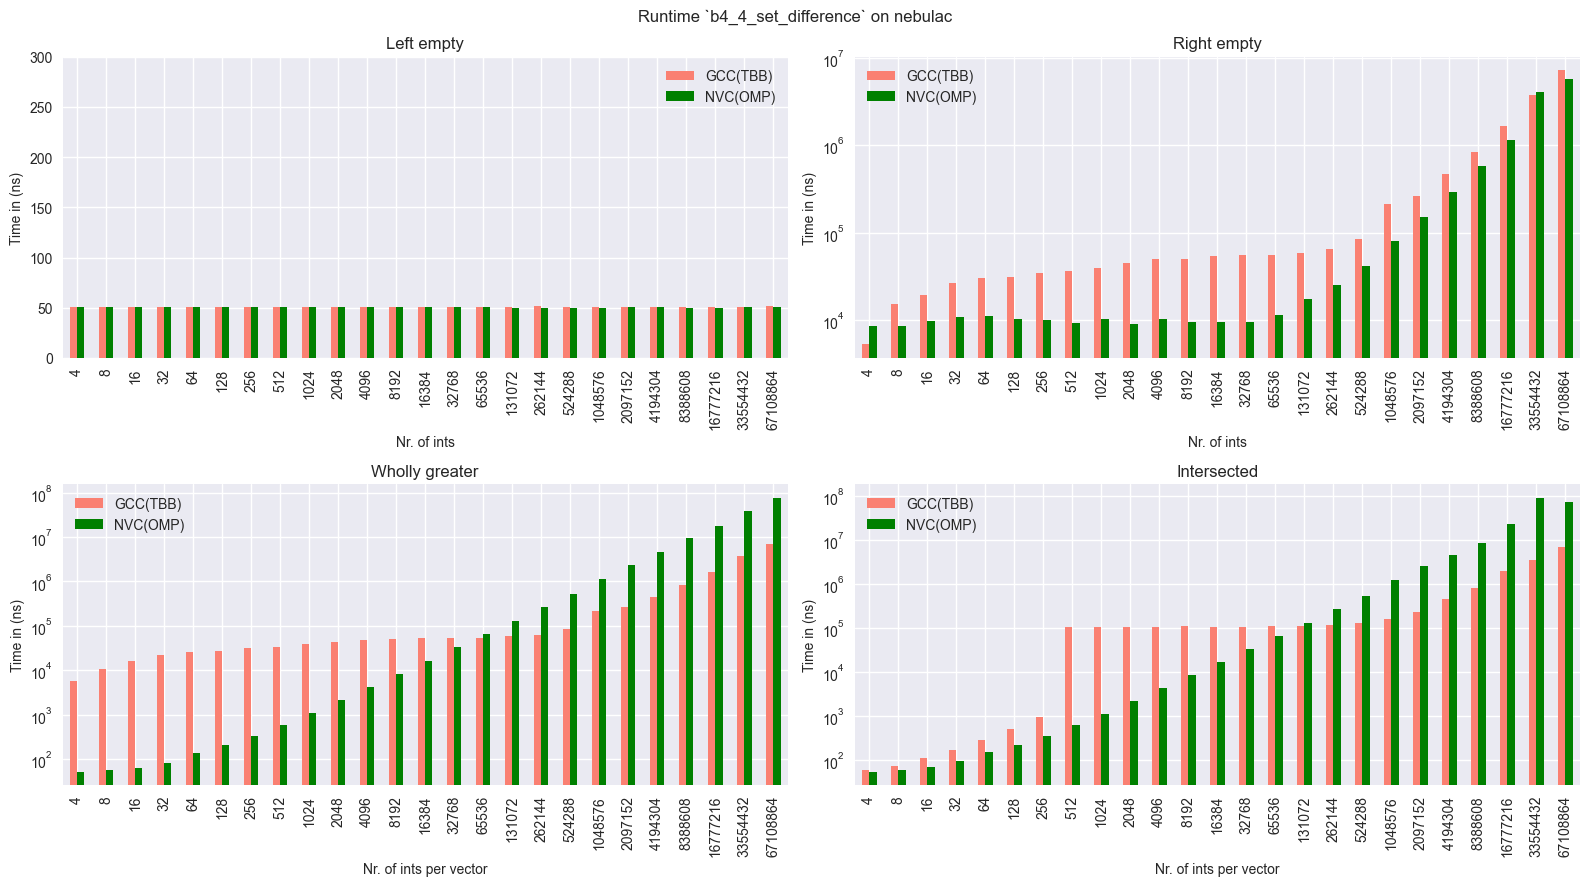

In [325]:
# all set_difference graphs

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 9))


# left empty
ax_1 = b4_4_set_difference_cutoff_left_empty_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Left empty')
ax_1.set_ylim(0,300)

# right empty
ax_2 = b4_4_set_difference_cutoff_right_empty_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,1])

ax_2.set_yscale('log', base=10)
ax_2.set_ylabel('Time in (ns)')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Right empty')


# wholly greater
ax_3 = b4_4_set_difference_cutoff_wholly_greater_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,0])

ax_3.set_yscale('log', base=10)
ax_3.set_ylabel('Time in (ns)')
ax_3.set_xlabel('Nr. of ints per vector')
ax_3.set_title('Wholly greater')


# intersected
ax_4 = b4_4_set_difference_cutoff_intersected_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,1])

ax_4.set_yscale('log', base=10)
ax_4.set_ylabel('Time in (ns)')
ax_4.set_xlabel('Nr. of ints per vector')
ax_4.set_title('Intersected')

fig.suptitle(f"Runtime `b4_4_set_difference` on {device_name}")

fig.tight_layout()

plot(f"`b4_4_set_difference` Runtime on {device_name}")

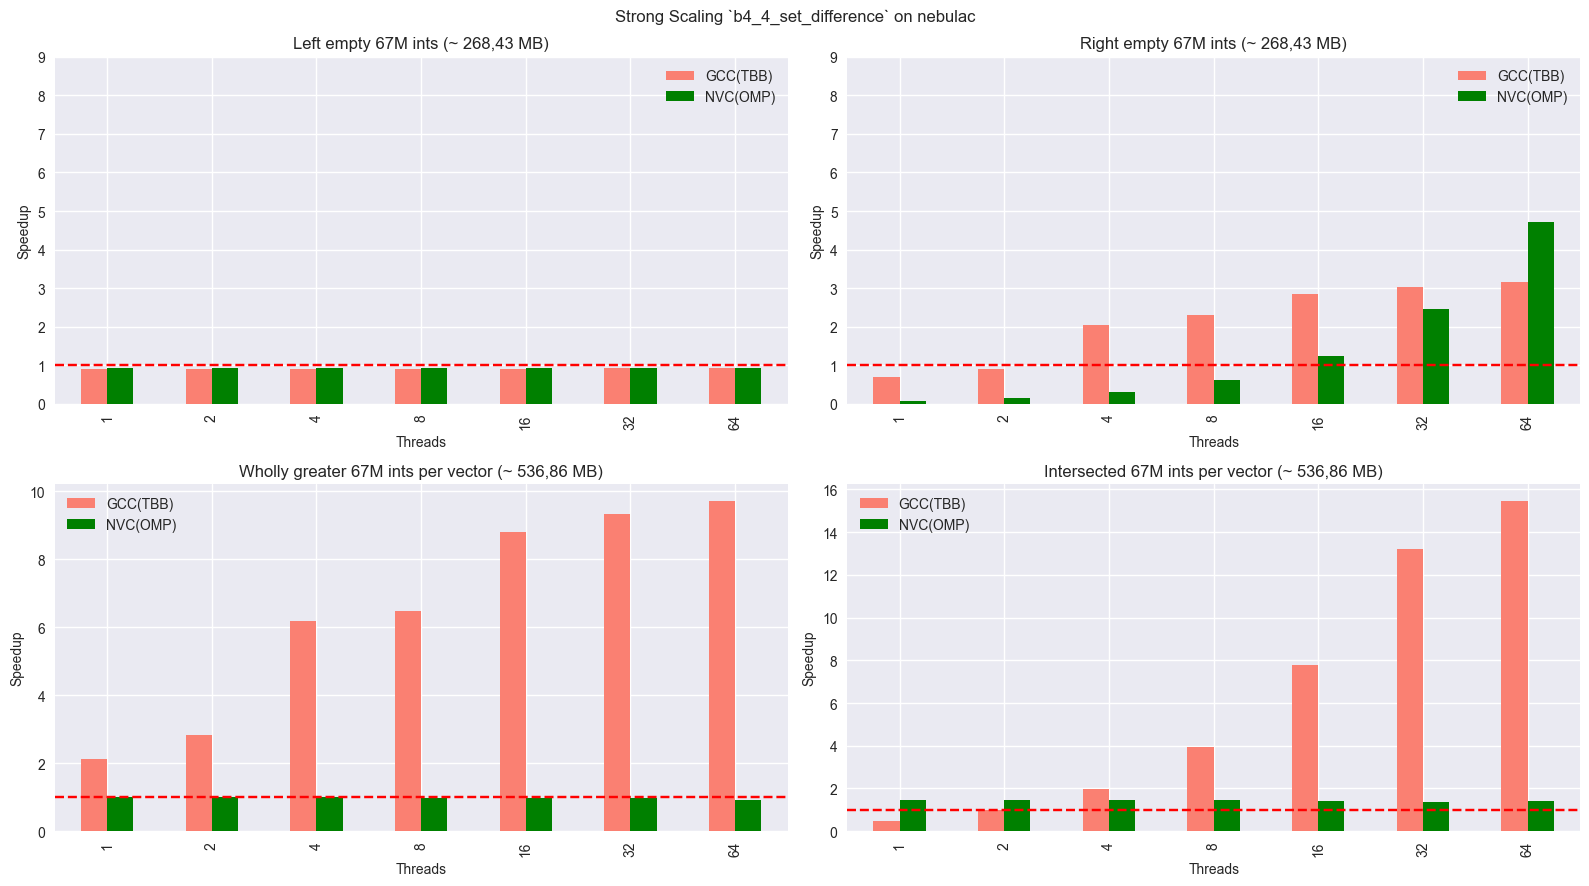

In [326]:
# strong scaling graphs


fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 9))


# left empty
ax_1 = b4_4_set_difference_cutoff_left_empty_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,0])

ax_1.set_ylabel('Speedup')
ax_1.set_xlabel('Threads')
ax_1.set_title('Left empty 67M ints (~ 268,43 MB)')
ax_1.axhline(y=1, color='r',linestyle='--')
ax_1.set_ylim(0,9)

# right empty
ax_2 = b4_4_set_difference_cutoff_right_empty_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,1])

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Right empty 67M ints (~ 268,43 MB)')
ax_2.axhline(y=1, color='r',linestyle='--')
ax_2.set_ylim(0,9)

# wholly greater
ax_3 = b4_4_set_difference_cutoff_wholly_greater_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,0])

ax_3.set_ylabel('Speedup')
ax_3.set_xlabel('Threads')
ax_3.set_title('Wholly greater 67M ints per vector (~ 536,86 MB)')
ax_3.axhline(y=1, color='r',linestyle='--')
#ax_3.set_ylim(0,9)

# intersected
ax_4 = b4_4_set_difference_cutoff_intersected_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,1])

ax_4.set_ylabel('Speedup')
ax_4.set_xlabel('Threads')
ax_4.set_title('Intersected 67M ints per vector (~ 536,86 MB)')
ax_4.axhline(y=1, color='r',linestyle='--')
#ax_4.set_ylim(0,9)

fig.suptitle(f"Strong Scaling `b4_4_set_difference` on {device_name}")

fig.tight_layout()

plot(f"`b4_4_set_difference` Strong Scaling on {device_name}")

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_18813/294865488.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_18813/294865488.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_18813/294865488.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_18813/294865488.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_4.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


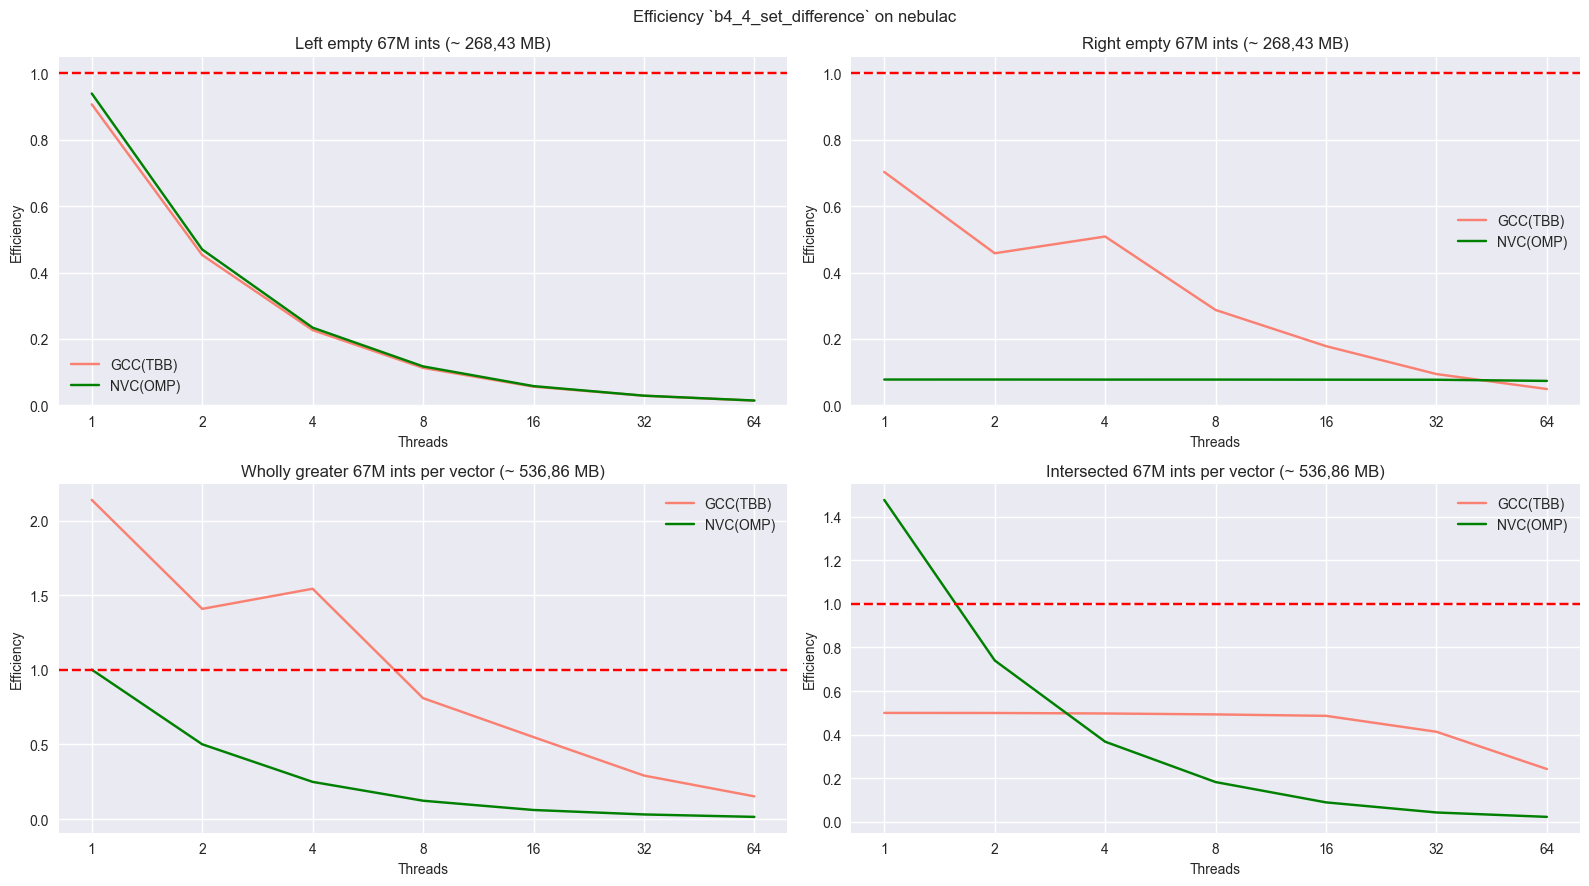

In [327]:
# efficiency graphs


fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 9))


# left empty
ax_1 = b4_4_set_difference_cutoff_left_empty_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,0])

ax_1.set_ylabel('Efficiency')
ax_1.set_xlabel('Threads')
ax_1.set_title('Left empty 67M ints (~ 268,43 MB)')
ax_1.axhline(y=1, color='r',linestyle='--')
ax_1.set_ylim(0,1.05)

ax_1.set_xscale('log', base=2)
current_values = ax_1.get_xticks()
ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# right empty
ax_2 = b4_4_set_difference_cutoff_right_empty_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,1])

ax_2.set_ylabel('Efficiency')
ax_2.set_xlabel('Threads')
ax_2.set_title('Right empty 67M ints (~ 268,43 MB)')
ax_2.axhline(y=1, color='r',linestyle='--')
ax_2.set_ylim(0,1.05)

ax_2.set_xscale('log', base=2)
current_values = ax_2.get_xticks()
ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# wholly greater
ax_3 = b4_4_set_difference_cutoff_wholly_greater_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,0])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Wholly greater 67M ints per vector (~ 536,86 MB)')
ax_3.axhline(y=1, color='r',linestyle='--')


ax_3.set_xscale('log', base=2)
current_values = ax_3.get_xticks()
ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# intersected
ax_4 = b4_4_set_difference_cutoff_intersected_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,1])

ax_4.set_ylabel('Efficiency')
ax_4.set_xlabel('Threads')
ax_4.set_title('Intersected 67M ints per vector (~ 536,86 MB)')
ax_4.axhline(y=1, color='r',linestyle='--')


ax_4.set_xscale('log', base=2)
current_values = ax_4.get_xticks()
ax_4.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])




fig.suptitle(f"Efficiency `b4_4_set_difference` on {device_name}")

fig.tight_layout()

plot(f"`b4_4_set_difference` Efficiency on {device_name}")

### Mbytes/s

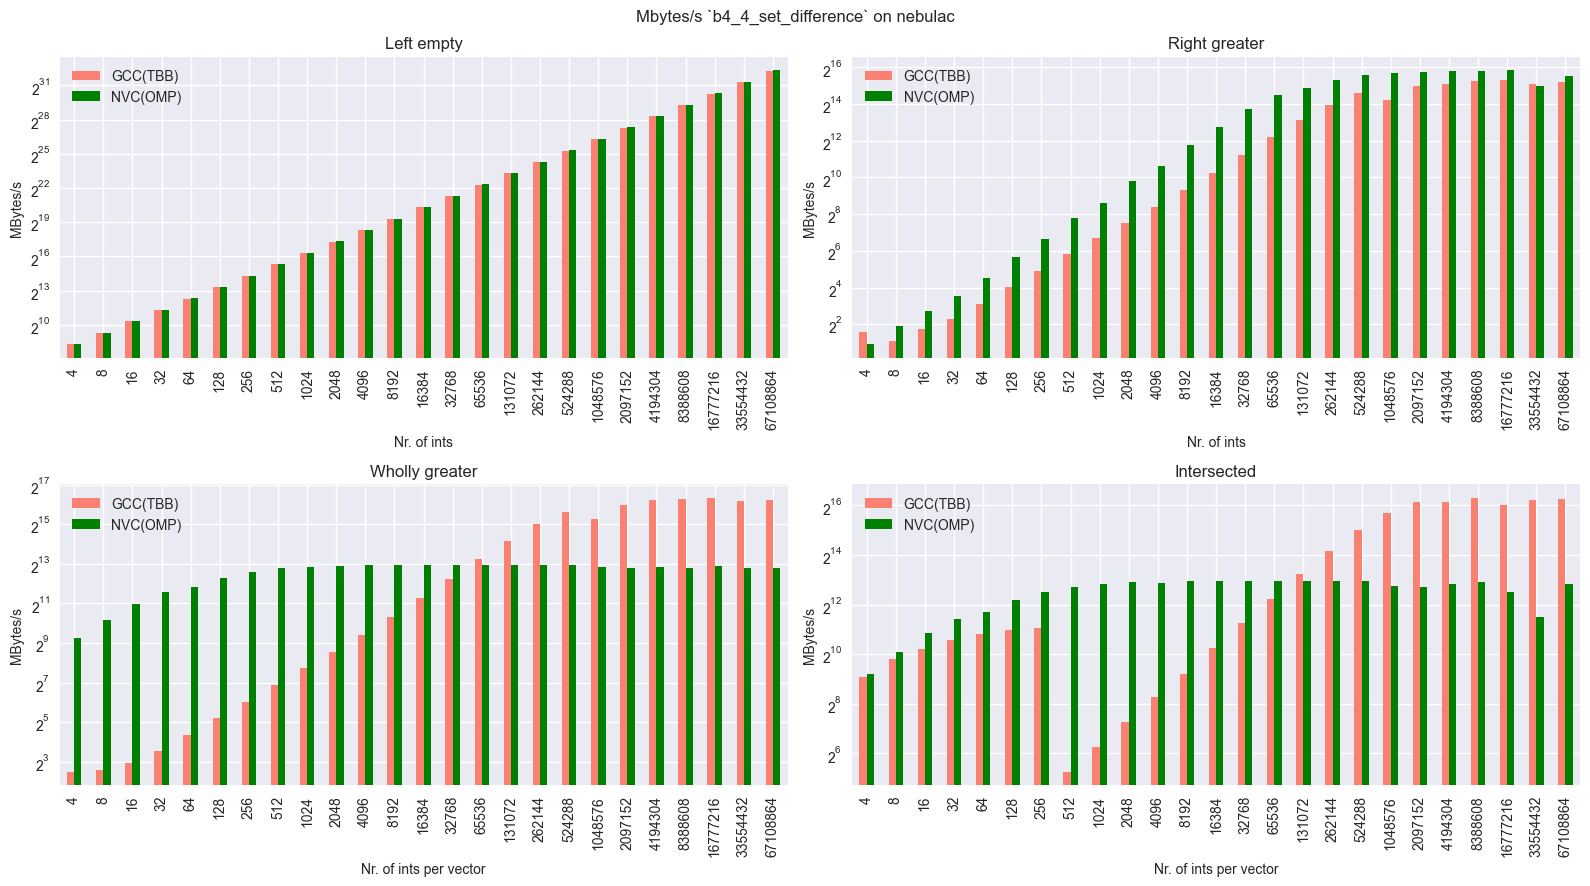

In [328]:
benchmark_names = [
    'b4_4_set_difference_cutoff_left_empty_par',
    'b4_4_set_difference_cutoff_right_empty_par',
    'b4_4_set_difference_cutoff_wholly_greater_par',
    'b4_4_set_difference_cutoff_intersected_par'
]


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

b4_4_mbytes_sec_data = {}

for benchmark_name in benchmark_names:
    # collect data for instances
    data = [bytes_per_second_data_algo(comp_location,comp_name,benchmark_name) for comp_location,comp_name in instances]

    b4_4_mbytes_sec_data[benchmark_name] = pd.merge(*data, on='n')




fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 9))



# plot left_empty
ax_1 = b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_left_empty_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[0,0]
                                                    )


ax_1.set_yscale('log',base=2)
ax_1.set_ylabel('MBytes/s')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Left empty')




# plot right empty
ax_2 = b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_right_empty_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[0,1]
                                                    )


ax_2.set_yscale('log',base=2)
ax_2.set_ylabel('MBytes/s')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Right greater')


# plot front_overhang
ax_3 = b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_wholly_greater_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1,0]
                                                    )

ax_3.set_yscale('log',base=2)
ax_3.set_ylabel('MBytes/s')
ax_3.set_xlabel('Nr. of ints per vector')
ax_3.set_title('Wholly greater')



# plot intersected
ax_4 = b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_intersected_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1,1]
                                                    )

ax_4.set_yscale('log',base=2)
ax_4.set_ylabel('MBytes/s')
ax_4.set_xlabel('Nr. of ints per vector')
ax_4.set_title('Intersected')


fig.suptitle(f"Mbytes/s `b4_4_set_difference` on {device_name}")

fig.tight_layout()

plot(f"`b4_4_set_difference` Mbytes_s on {device_name}")

## Performance Portability Calculation (Inter Compiler)

In [329]:
def calc_pp(data_points:List[int]) -> int:
    min_val = min(data_points)
    return len(data_points) / sum([1/(min_val/val) for val in data_points])

compilers = ['GCC(TBB)','NVC(OMP)']

pp_df = pd.DataFrame(columns=['name','GCC(TBB)','NVC(OMP)','PP'])


data_fields = [
    ('B4_1',b4_1_merge_time_merged),
    
    ('B4_2_already_sorted',b4_2_stable_sort_cutoff_already_sorted_time_merged),
    ('B4_2_decrement_sorted',b4_2_stable_sort_cutoff_decrement_sorted_time_merged),
    ('B4_2_not_sorted',b4_2_stable_sort_cutoff_not_sorted_time_merged),
    
    ('b4_3_one_empty',b4_3_set_union_cutoff_one_empty_time_merged),
    ('b4_3_wholly_greater',b4_3_set_union_cutoff_one_wholly_greater_time_merged),
    ('b4_3_front_overhang',b4_3_set_union_cutoff_front_overhang_time_merged),
    
    ('b4_4_left_empty',b4_4_set_difference_cutoff_left_empty_time_merged),
    ('b4_4_right_empty',b4_4_set_difference_cutoff_right_empty_time_merged),
    ('b4_4_wholly_greater',b4_4_set_difference_cutoff_wholly_greater_time_merged),
    ('b4_4_intersected',b4_4_set_difference_cutoff_intersected_time_merged),
]


for data in data_fields:

    entry_dict = {
        'name': [data[0]],
    }

    vals = []

    for comp in compilers:
        current_val = int(data[1].iloc[-1][comp])
        entry_dict[comp] = [current_val]

        vals.append(current_val)

    entry_dict['PP'] = calc_pp(vals)

    other_df = pd.DataFrame.from_dict(entry_dict)
    pp_df = pd.concat([pp_df,other_df],ignore_index=True)


pp_df['INTERPRET'] = np.where(pp_df['PP']>0.85, 'GOOD', 'BAD')

pp_df

,name,GCC(TBB),NVC(OMP),PP,INTERPRET
0,B4_1,18204600,106429000,0.292130,BAD
1,B4_2_already_sorted,14215000,784804000,0.035581,BAD
2,B4_2_decrement_sorted,16405500,806711000,0.039862,BAD
3,B4_2_not_sorted,17851600,803920000,0.043447,BAD
4,b4_3_one_empty,7068040,5663390,0.889671,GOOD
5,b4_3_wholly_greater,14361600,83830300,0.292521,BAD
6,b4_3_front_overhang,63860900,124686000,0.677401,BAD
7,b4_4_left_empty,51,50,0.990099,GOOD
8,b4_4_right_empty,7142380,5768920,0.893623,GOOD
9,b4_4_wholly_greater,7085710,76790200,0.168957,BAD


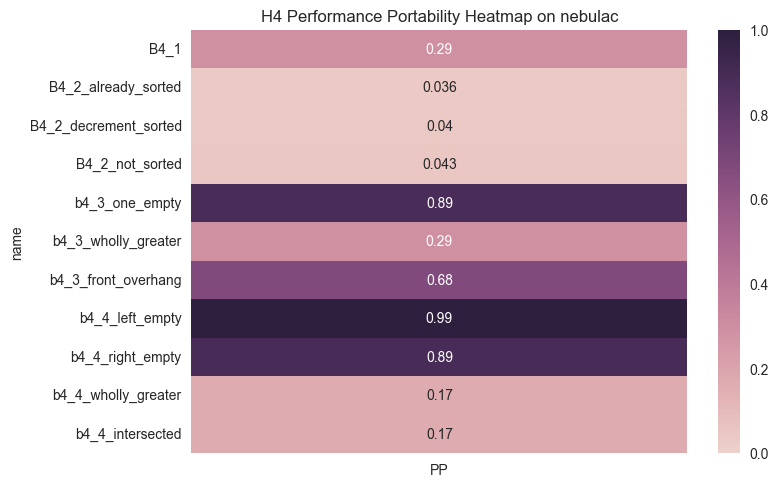

In [330]:
import seaborn as sns

heatmap_pp_df = pp_df.copy()
heatmap_pp_df = heatmap_pp_df.drop(columns=['GCC(TBB)','NVC(OMP)','INTERPRET'])
heatmap_pp_df = heatmap_pp_df.set_index(['name'])


sns.heatmap(heatmap_pp_df, annot=True,cmap=sns.cubehelix_palette(as_cmap=True),vmin=0,vmax=1)

plt.title(f'H4 Performance Portability Heatmap on {device_name}')

plot(f'H4 Performance Portability Heatmap on {device_name}')

In [331]:
# saving pp into file
pp_save_location = f'/Users/diego/Documents/Studium/4_Semester/Masterarbeit/master_benchmarks/analysis/Performance_Portability/data/{device_name.upper()}_H4_pp.csv'
pp_df.to_csv(pp_save_location)

## Findings for H4

### Findings `b4_1_merge`



### Findings `b4_2_stable_sort`



### Findings `b4_3_set_union`



### Findings `b4_4_set_difference`



### General



### GPU Findings



### Hypothesis Findings

